## Install Libraries

In [66]:
# !pip install opencv-python

In [67]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm 

## Define Constants

In [68]:
HOME = os.getcwd()
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
print(HOME)

/Users/ivynyak/Documents/GitHub/scdf-dell-2024


## Resize Images

In [69]:
def resize_all(path, length, X, Y):
    for i in tqdm(range(1, length + 1), desc='Processing images'):
        IMG_PATH = f"{HOME}{path}images/img({i}).jpg"
        MASK_PATH = f"{HOME}{path}masks/img({i}).png"

        img = imread(IMG_PATH)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[i-1] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
        mask_ = imread(MASK_PATH)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)

        Y[i-1] = mask

    return X, Y

In [73]:
TRAIN_PATH = '/dataset/train/'
TEST_PATH = '/dataset/test/'

TRAIN_LENGTH = len(os.listdir(HOME + '/dataset/train/images')) -1 
TEST_LENGTH = len(os.listdir(HOME + '/dataset/test/images')) -1 

X_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(HOME + '/dataset/train/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

X_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(HOME + '/dataset/test/images')), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)


In [74]:
X_test, Y_test = resize_all(TEST_PATH, TEST_LENGTH, X_test, Y_test)

Processing images: 100%|██████████████████████| 100/100 [00:07<00:00, 12.69it/s]


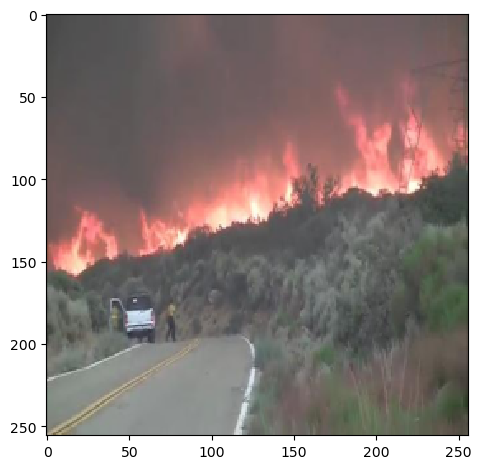

In [75]:
image_test = random.randint(0, TEST_LENGTH)

## Show actual vs masked image
img = X_test[image_test]
imshow(img)

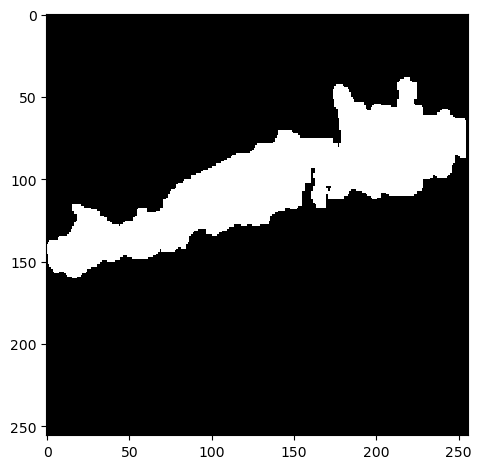

In [76]:
img = np.squeeze(Y_test[image_test])
imshow(img)

In [77]:
X_train, Y_train = resize_all(TRAIN_PATH, TRAIN_LENGTH, X_train, Y_train)

Processing images: 100%|██████████████████████| 600/600 [01:47<00:00,  5.58it/s]


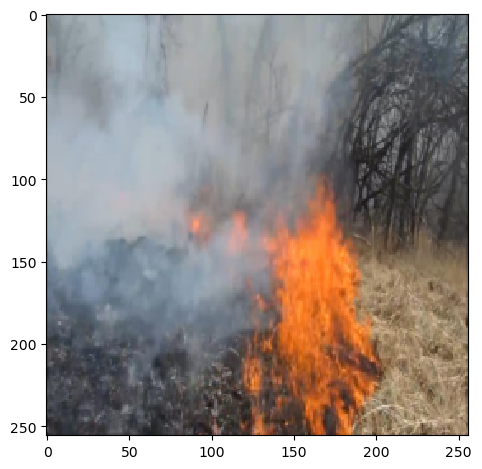

In [78]:
image_train = random.randint(0, TRAIN_LENGTH)

## Show actual vs masked image
img = X_train[image_train]
imshow(img)

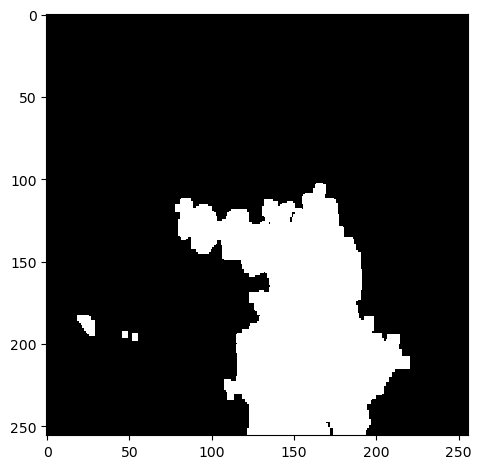

In [79]:
img = np.squeeze(Y_train[image_train])
imshow(img)

## U-Net Set Up

In [80]:
def custom_lambda(x):
    return x / 255


In [81]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(custom_lambda)(inputs)

#contraction
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


In [82]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("fire_segmentation.keras", verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs/'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

]

In [84]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.9135 - loss: 0.3595 - val_accuracy: 0.8804 - val_loss: 0.3538 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 1003s 30s/step - accuracy: 0.9254 - loss: 0.1442 - val_accuracy: 0.8804 - val_loss: 0.2108 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 340s 10s/step - accuracy: 0.9188 - loss: 0.1362 - val_accuracy: 0.8826 - val_loss: 0.2094 - learning_rate: 0.0010
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.9394 - loss: 0.1208 - val_accuracy: 0.9491 - val_loss: 0.2036 - learning_rate: 0.0010
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.9576 - loss: 0.1259 - val_accuracy: 0.9531 - val_loss: 0.1483 - learning_rate: 0.0010
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.9660 - loss: 0.1023 - val_accuracy: 0.9471 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.9678 - loss: 0.0936 - val_

## Evaluation

In [85]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [86]:
print(len(preds_test))

101


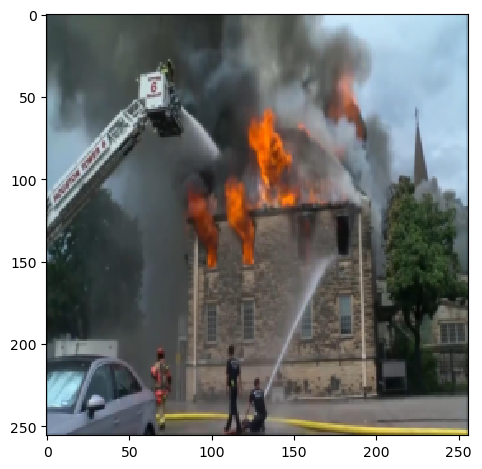

In [87]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])

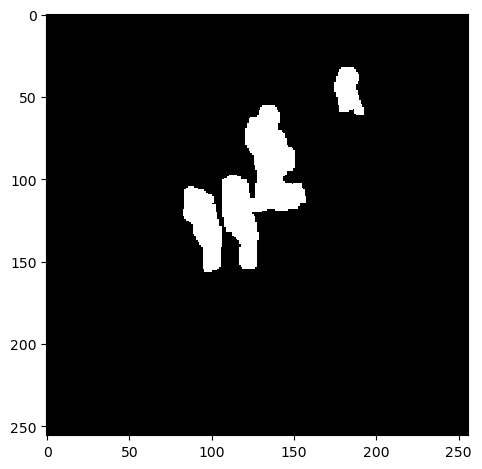

In [88]:
imshow(np.squeeze(Y_train[ix]))

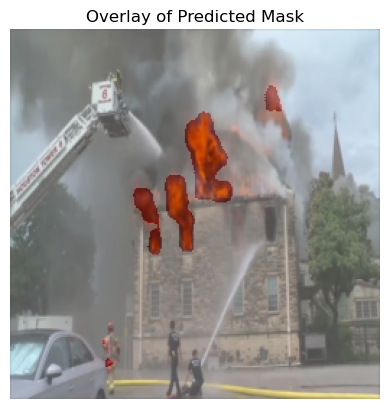

In [89]:
# imshow(np.squeeze(preds_train_t[ix]))
original_img = X_train[ix]
predicted_mask = preds_train_t[ix]

if predicted_mask.shape[-1] == 1:
    predicted_mask = np.squeeze(predicted_mask, axis=-1)

# Display the original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Overlay the mask on top of the image with a transparency
plt.imshow(predicted_mask, alpha=0.3, cmap='Reds')
plt.title("Overlay of Predicted Mask")
plt.axis('off')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


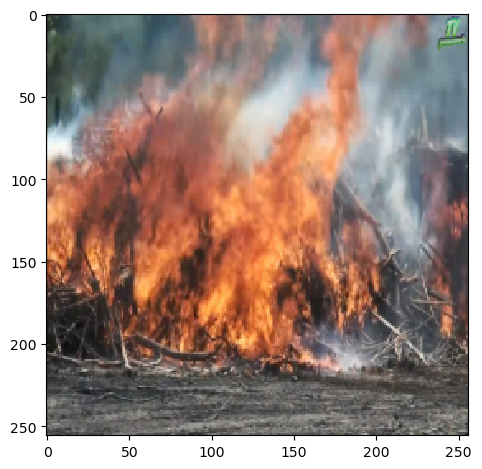

In [90]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])

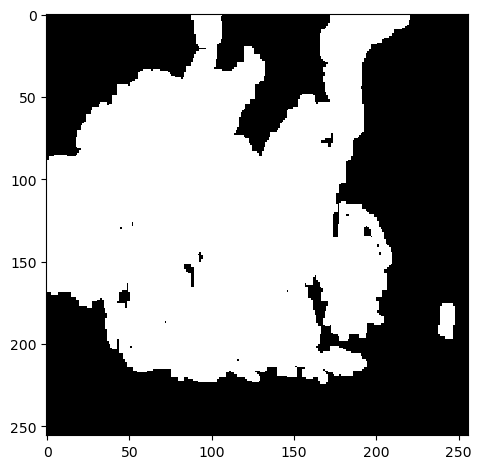

In [91]:
imshow(np.squeeze(Y_test[ix]))

In [92]:
# imshow(np.squeeze(preds_test_t[ix]))


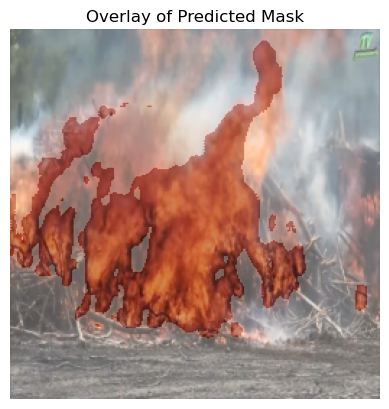

In [93]:
original_img = X_test[ix]
predicted_mask = preds_test_t[ix]

if predicted_mask.shape[-1] == 1:
    predicted_mask = np.squeeze(predicted_mask, axis=-1)

# Display the original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Overlay the mask on top of the image with a transparency
plt.imshow(predicted_mask, alpha=0.3, cmap='Reds')
plt.title("Overlay of Predicted Mask")
plt.axis('off')
plt.show()

## Categorisation

0.008941650390625 3


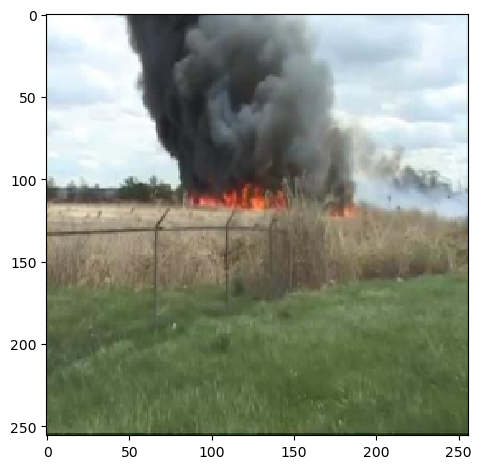

In [94]:
idx = random.randint(0, len(Y_test))
mask = np.array(preds_test_t[idx])

true_count = np.count_nonzero(mask)

ratio = true_count/(mask.size)

if ratio == 0:
    category = 4
elif ratio < 0.01:
    category = 3
elif ratio < 0.05:
    category = 2
else:
    category = 1

print(ratio, category)
imshow(X_test[idx])


In [95]:
model.save("fire_segmentation.keras", save_format='tf')

In [96]:
# import os
# import shutil

# test_img = "dataset/test/images"
# train_img = "dataset/train/images"
# test_mask = "dataset/test/masks"
# train_mask = "dataset/train/masks"
    
# imgs = os.listdir(test_img)
# masks = os.listdir(test_mask)

# img_files = [i for i in imgs if i.endswith('.jpg')]
# mask_files = [i for i in masks if i.endswith('.png')]

# count = 501

# # for old_name in mask_files:

# #     new_name = f"img({count}).jpg"  # Adjust format as needed
    
# #     old_path = os.path.join(test_mask, old_name)
# #     new_path = os.path.join(train_mask, new_name)
    
# # #     shutil.copy(old_path, new_path)

# #     print(old_path, new_path)
# #     count += 1

# names = []
    
# for i in img_files:
#     i = i.replace(".jpg", "")
#     names.append(i)
    

# for name in names:
#     img = name + ".jpg"
#     mask = name + ".png"
    
#     new_img = f"img({count}).jpg"
#     new_mask = f"img({count}).png"
    
#     old_img = os.path.join(test_img, img)
#     new_img = os.path.join(train_img, new_img)
    
#     old_mask = os.path.join(test_mask, mask)
#     new_mask = os.path.join(train_mask, new_mask)
    
#     shutil.copy(old_img, new_img)
#     shutil.copy(old_mask, new_mask)

#     count += 1

# #     print(old_img, new_img, new_mask)
    

# print("Renaming complete.")

In [97]:
len(os.listdir(HOME + '/dataset/test/images'))


101